## In this first part I would like to check out the data and answer the following questions

1. how does it look like
2. how do the masks correspond to the images
3. how many labels are there
4. how many samples per class do we have and are there imbalances between classes
5. what is the format of the images + masks (size + further dimensions)
6. which kind of data-augmentation can be applied to the data or is the prediction sensitive to transformation


One stupid thing happened.....guess who forgot to read the "pointers" section of the README and the pyradiomics idea. Well, it probably makes sense to use it, but I will just stick to my original, image-based idea without the a priori knowledge included from radiometric features. I am not sure how the model will perform without this, but hey lets find out

In [1]:
# List files and pair with masks

import os

dir_names = ["data/images/","data/masks/"]

# first the images
image_filenames = []
for path in os.listdir(dir_names[0]):
    if(os.path.isfile(os.path.join(dir_names[0], path))):
        image_filenames.append(path) # we only want the filename, as they are the same for images and masks folder
        
# check, whether we have matching masks for each image in the masks folder

missing_mask = False

#just iterate through every filename in the image_filenames list and check whether it exists in the mask folder
for filename in image_filenames:
    if(not os.path.isfile(os.path.join(dir_names[1], filename))):
        missing_mask = True # when one is missing, set this bool to True
        
assert missing_mask == False, "images and mask files not matching!"

## Get some stats about number of samples, classes and visualize some samples


At this point I was not sure, whether liver4,7,8 are own classes or just regions of the same liver, so liver would be one single class. The same goes for kidney[l/r] -> shall I create an own class for left and right or are they the same class ? To clarrify this, I wanted to proceed with just displaying the images first and colnclude then, if I should put them in the same class or not. My idea right now is, that they are regions of the same organ (as also described in the README) and I would treat them as the same class. Not sure for l/r expressions of the same organ, so lets see....

In [2]:
import nrrd
import numpy as np


import matplotlib.pyplot as plt

# get an impression for the returns of the nrrd file read operation, so load first file from list

image_data, image_header = nrrd.read(dir_names[0]+image_filenames[0])
mask_data, mask_header = nrrd.read(dir_names[1]+image_filenames[0])

print(image_header)
print(mask_header)



OrderedDict([('type', 'double'), ('dimension', 2), ('sizes', array([15, 15])), ('endian', 'little'), ('encoding', 'gzip')])
OrderedDict([('type', 'double'), ('dimension', 2), ('sizes', array([15, 15])), ('endian', 'little'), ('encoding', 'gzip')])


looks like I get a numpy array back, with 2 dimensions and 15x15 size, as intended. So its a double type image with one channel, lets check the range of each pixel and normalize it if needed to have the best image dynamics for displaying

/tmp/ipykernel_132896/29855336.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_images.show()
/tmp/ipykernel_132896/29855336.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_masks.show()


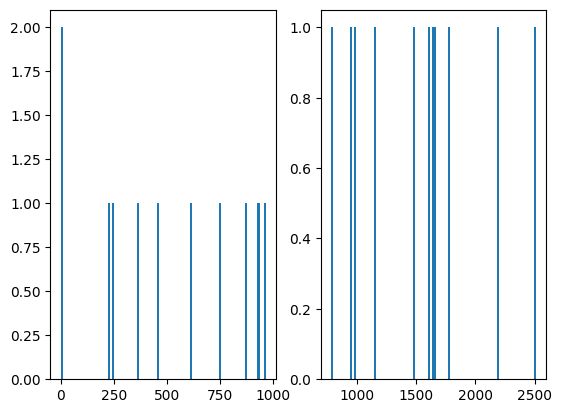

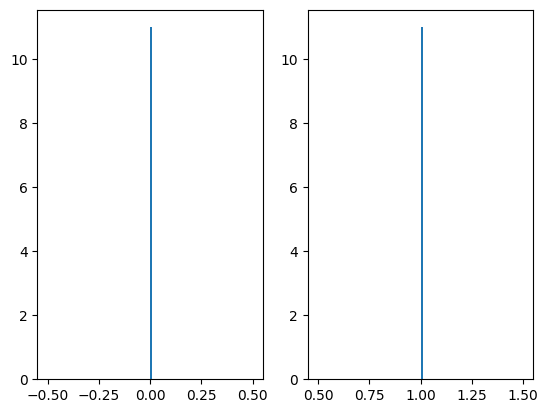

In [3]:
# visualize min/max values of images to know how to scale them later and whether its already scaled somehow

images_mins = []
images_maxs = []
masks_mins = []
masks_maxs = []



for filename in image_filenames:
    absolute_filenames = [dir_names[i]+filename for i in range(2)] # absolute filenames for images and masks
    
    if(filename.split("_")[0] == "1"): # we want the files from the first batch only
        image_data, _ = nrrd.read(absolute_filenames[0])
        mask_data, _ = nrrd.read(absolute_filenames[1])
        
        images_mins.append(np.amin(image_data))
        images_maxs.append(np.amax(image_data))
        masks_mins.append(np.amin(mask_data))
        masks_maxs.append(np.amax(mask_data))
        
        
# display distribution of min and max values for images and masks

fig_images, axs_images = plt.subplots(1, 2)
axs_images[0].hist(images_mins, bins=100)
axs_images[1].hist(images_maxs, bins=100)

fig_images.show()

fig_masks, axs_masks = plt.subplots(1, 2)
axs_masks[0].hist(masks_mins, bins=100)
axs_masks[1].hist(masks_maxs, bins=100)

fig_masks.show()


Looks like masks are already from 0-1 range, images are somewhere between 0-2500. It would make sense to scale them to 0-1 as well, but check later, if there is any meaning to the values or physical unit which makes sense to preserve 

/tmp/ipykernel_132896/31840991.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1_bonel1.nrrd
1_musclel.nrrd
1_liver8.nrrd
1_kidneyl.nrrd
1_spleenl.nrrd
1_bonel2.nrrd
1_liver7.nrrd
1_muscler.nrrd
1_kidneyr.nrrd
1_liver4.nrrd
1_spleenr.nrrd


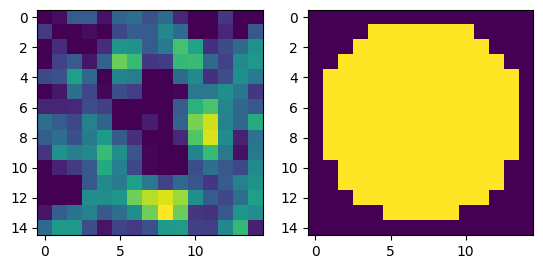

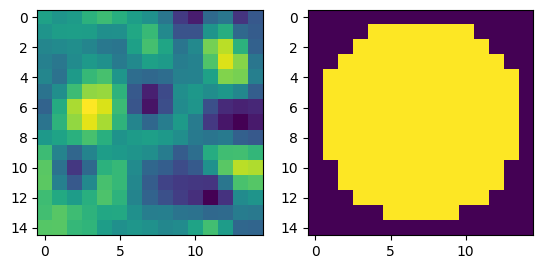

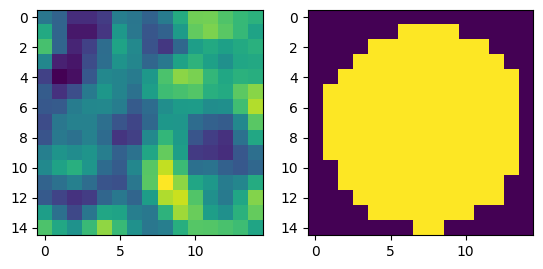

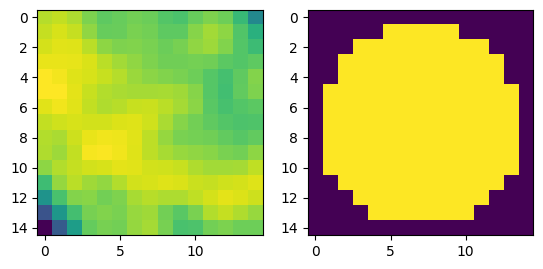

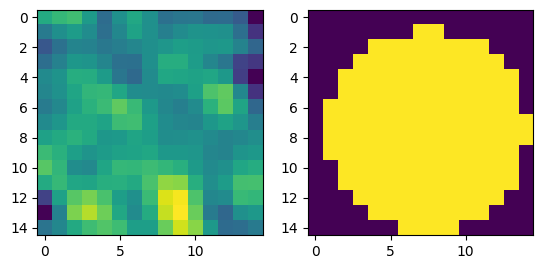

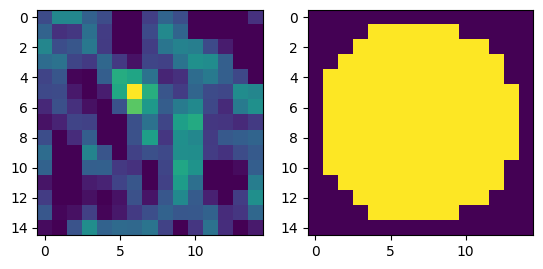

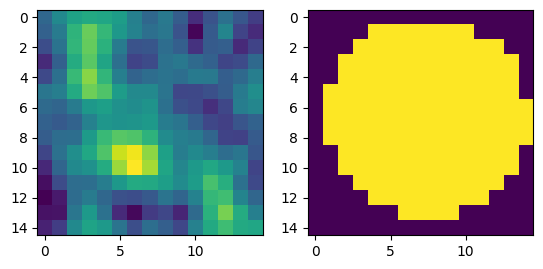

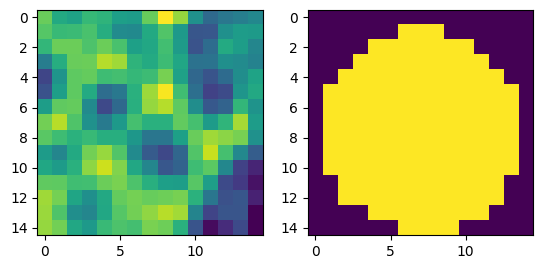

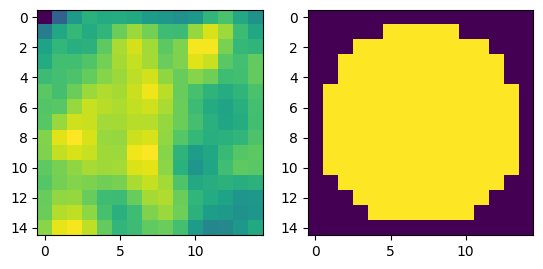

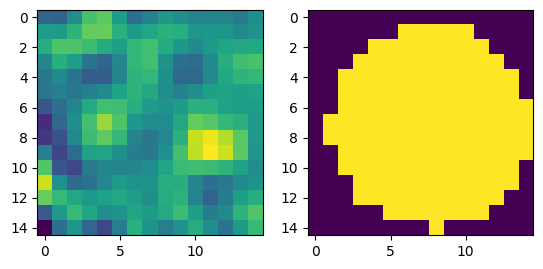

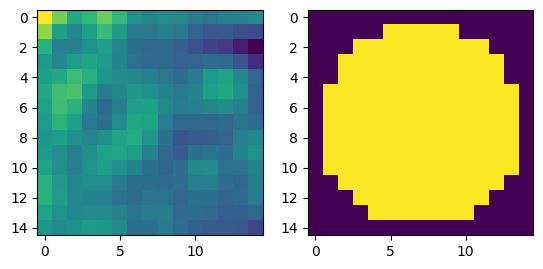

In [7]:
#write a normalization function for an image

def normalizeImage(image):
    max_val = np.amax(image)
    min_val = np.amin(image)
    scaled_image = (image-min_val)/(max_val-min_val)
    return scaled_image

# display the image pairs
for filename in image_filenames:
    absolute_filenames = [dir_names[i]+filename for i in range(2)] # absolute filenames for images and masks

    if(filename.split("_")[0] == "1"): # we want the files from the first batch only
        image_data, _ = nrrd.read(absolute_filenames[0])
        mask_data, _ = nrrd.read(absolute_filenames[1])
        
        image_scaled = normalizeImage(image_data)
        
        print(filename)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(image_scaled)
        axs[1].imshow(mask_data)
        fig.show()

    


I would like to see how samples from different batches look like, lets take kidneyl for example

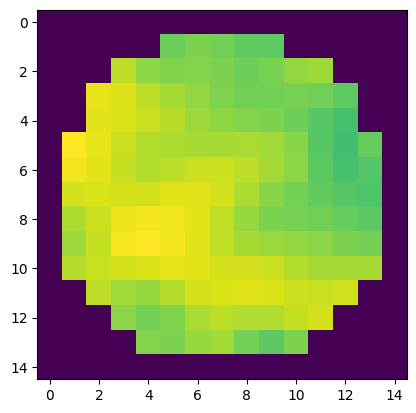

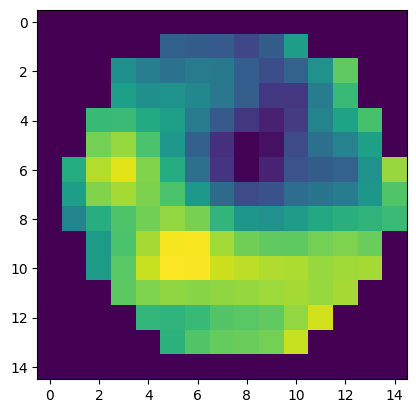

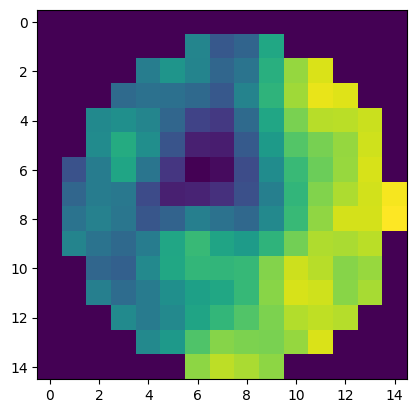

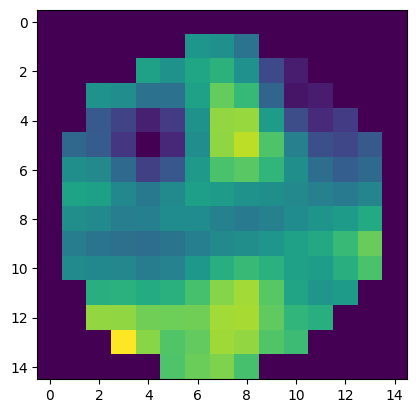

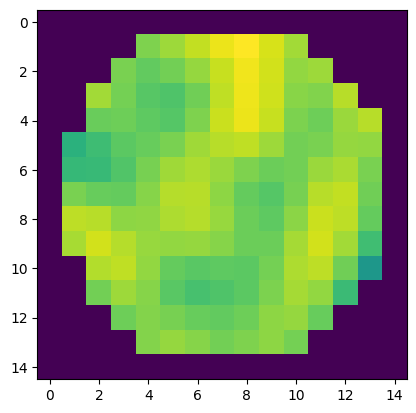

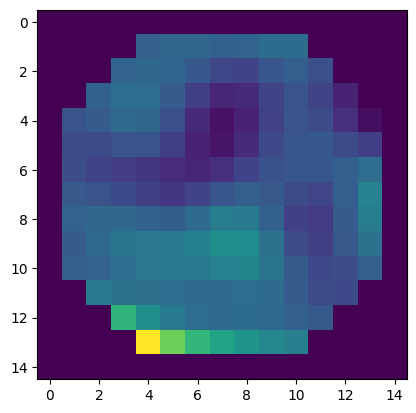

In [9]:
organ_slice = "kidneyl" # what we want to search for

for filename in image_filenames:
    absolute_filenames = [dir_names[i]+filename for i in range(2)] # absolute filenames for images and masks

    if(organ_slice in filename): 
        image_data, _ = nrrd.read(absolute_filenames[0])        
        mask_data, _ = nrrd.read(absolute_filenames[1])

        image_scaled = normalizeImage(image_data) * mask_data # lets do comp-wise mul for ROI content selection
        
        plt.figure()
        plt.imshow(image_scaled)
        plt.show()

So far we got 15x15 images, the mask will cut off not important parts, as it works as the ROI.
There are 5 different organs, so we got 5 classes.
The image can be normalized to match 0-1 range 
We have a slight class imbalance between liver class and the others, which are evenly distributed
I cant assume, that a rotation is "okay" here, because it may be, that the orientation of the structures plays a role. I could include some data-augmentation and therefore end up using another model type.

## Ideas for model creation so far

1. before inference, we could do semi-supervised learning with soft-labels of the inference data first to adapt unseen samples with its class-distribution. This would be good, when we have a small amount of samples or high class-imbalance

2. there are only 6 batches of data available, with 2-3 samples per batch for the same organ, which is very limited. It would make sense to use a few-show learning approach here, something like siamese network with contrastive loss or prototypical networks. But as the dimensionality of the data is very small, even when we see the binary mask, which is a circle of area pi*r² -> pi*(7.5)² for the 15x15 image, which is ~ 176 pixels, the acctual amount of information is pretty small. When we take 2 out of 6 batches for testing, we end up with something like 8-12 samples per class, which is very small. I thought about autoencoders and then train a classifier head on it, which is similar to the prototypical network approach, where we can find some similarities between in-class samples. I will go with the prototypical networks here, because we have so few samples per class, so we have a 5-way-(8-12)-shot learning problem here without any data augmentation.


I spent quite some time now on gathering some ideas for the network approach, as I was not sure how to proceed with the data augmentation. I would need some more information about the data, whether its allowed to transform it in any ways, but without it, I will go with the few-shot approach for now.
Also I thought about the way I want to treat the mask. A simple multiplication would select the ROI, but results in a skewed input distribution, as there are many 0-pixels. This could be a problem, but as the distribution of the image stays the same all the time, I guess thats fine. There are better ways to do it with partial convolution for example, but this is beyond scope again....ahh so many ideas, so little time :) 








In [19]:
import re

# create a training and testing set and save it as numpy arrays to load in the next notebook for training

class_names = ["bone","kidney","liver","muscle","spleen"]
set_x = []
set_y = []

#first we will sort the filenames to be in ascending batch number, so we can later just cut the set into train and test
# by using the last 11*2 samples (for 2 batches a 11 samples)
image_filenames.sort(key=lambda f: int(f.split("_")[0]))

sorted_image_filenames = image_filenames

for filename in sorted_image_filenames:
    absolute_filenames = [dir_names[i]+filename for i in range(2)] # absolute filenames for images and masks

    for j,class_name in enumerate(class_names):
        if(class_name in filename): 
            image_data, _ = nrrd.read(absolute_filenames[0])        
            mask_data, _ = nrrd.read(absolute_filenames[1])

            image_scaled_roi = normalizeImage(image_data) * mask_data # lets do comp-wise mul for ROI content selection
            
            set_x.append(image_scaled)
            set_y.append(j) #j is the index of the class we currently get from the filename class string
           
            
set_x = np.array(set_x)
set_y = np.array(set_y)

print("set x shape:",set_x.shape)
print("set y shape:",set_y.shape)


set x shape: (66, 15, 15)
set y shape: (66,)


In [24]:
TRAIN_BATCHES = 4  # specify how many batches we use for training, rest is testing

assert TRAIN_BATCHES > 0
assert TRAIN_BATCHES < (set_x.shape[0]//11)

train_x = set_x[:(TRAIN_BATCHES*11)]
train_y = set_y[:(TRAIN_BATCHES*11)]
test_x = set_x[(TRAIN_BATCHES*11):]
test_y = set_y[(TRAIN_BATCHES*11):]


np.save("trainx",train_x)
np.save("trainy",train_y)
np.save("testx",test_x)
np.save("testy",test_y)

